# 1. Packages

In [65]:
# --- Core data handling
import pandas as pd 
import numpy as np 
import pyarrow

# --- Visualizations
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go 

# --- Statistics and Modeling
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce

# --- File I/O & utilities
import openpyxl
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# 2. Data information

In [66]:
df = pd.read_csv ("games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# 3. Data cleaning and preparation

### 🧹 Data Preparation and Cleaning

During this stage, the dataset was cleaned and standardized to ensure that all columns had the proper format for analysis and that only relevant records remained.

First, all column names were cleaned by removing extra spaces and converting them to lowercase. This provided a consistent and easy-to-use naming convention throughout the project.

Next, the **year_of_release** column was converted from *float* to *integer* (`Int64`). Since years should not appear with decimal values, this step ensured that each year was represented correctly while still allowing missing entries to remain as null values.

The **user_score** column contained some non-numeric entries such as “TBD” (To Be Determined), which indicate that a user score had not yet been assigned. These values were replaced with missing values (`NaN`), and the column was then converted to a numeric format. This allows mathematical and statistical operations to be performed safely on user scores.

Similarly, the **rating** column, which represents the ESRB classification of each game, had missing values that were replaced with the word **“Unknown.”** This ensures that games without an official rating can still be included in summaries and visualizations without producing errors.

After standardizing column formats, rows missing critical information such as the **game name** or **genre** were removed. Records without these attributes cannot contribute meaningful insights to the analysis, as they cannot be identified or categorized by type.

To maintain data integrity, duplicate entries were also removed based on the combination of **name** and **platform**, keeping only the first occurrence of each unique pair. Additionally, games missing the **year_of_release** were dropped since the release year is essential for studying temporal trends and forecasting.

Finally, a new column called **total_sales** was created by summing the regional sales across **North America, Europe, Japan, and Other regions.** This provides a unified measure of each game’s overall commercial performance and will be used extensively in the exploratory and comparative analyses.

Through these transformations, the dataset is now clean, consistent, and fully ready for exploratory data analysis, ensuring that all future findings are based on reliable and well-structured information.


In [67]:
# Columnns standardization and cleaning
df.columns = df.columns.str.strip().str.lower()

# Convert release year to integer, keeping NaN for missing entries 
df["year_of_release"] = (
    pd.to_numeric (df["year_of_release"], errors="coerce")
    .round()
    .astype ("Int64")
)

# Replace 'tbd' with NaN and convert user_score to numeric
us = df["user_score"].astype (str).str.strip().str.lower()
us = us.replace ({"tbd": np.nan})
df["user_score"] = pd.to_numeric (us, errors="coerce")

# Replace NaN in rating with 'unknown'
df["rating"] = df["rating"].replace (np.nan, "unknown")


# Remove games without name and genre
df = df.dropna (subset=["name", "genre"])

# Remove duplicates based on name and platform, keeping the first occurrence
df = df.drop_duplicates (subset=["name", "platform"], keep="first") 

# Remove missing values in year_of_release
df = df.dropna (subset = ["year_of_release"])

# Remove outlier value for DS platform since it doesn't make sense

df = df[~((df["platform"] == "DS") & (df["year_of_release"] < 2004))]

# Create a new column for total sales
df["total_sales"] = df[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum (axis=1)



# 3. EDA

### 📊 Business Intelligence & Market Analysis

**Strategic Overview:** This section provides executive-level insights into gaming industry market dynamics, platform performance, and genre profitability trends. The analysis focuses on actionable business intelligence for strategic decision-making, competitive positioning, and market opportunity identification.

**Key Business Questions Addressed:**
- 💰 Which platforms generate the highest revenue and market share?
- 🎮 What genres offer the best ROI and growth potential?
- 📈 How has market performance evolved over time?
- 🏆 Who are the market leaders and why?

In [68]:
# Yearly total sales and games count 
sales_by_year = (
    df.groupby("year_of_release", as_index=False)
    .agg (total_sales = ("total_sales", "sum"), 
          games_count = ("name", "count"))
          .sort_values ("year_of_release")
)

# Yearly sales by platform 

sales_platform_year = (
    df.groupby (["platform", "year_of_release"], as_index= False)
    .agg (total_sales = ("total_sales", "sum"))
)

#Platform totals
platform_sales = (
    df.groupby ("platform", as_index = False)
    .agg (total_sales = ("total_sales", "sum"), 
          games_count = ("name", "count"))
          .sort_values ("total_sales", ascending= False)
)

# Genre totals 
genre_sales = (
    df.groupby ("genre", as_index= False).
    agg (total_sales = ("total_sales", "sum"), 
         games_count = ("name", "count"))
         .sort_values ("total_sales", ascending= False)
)

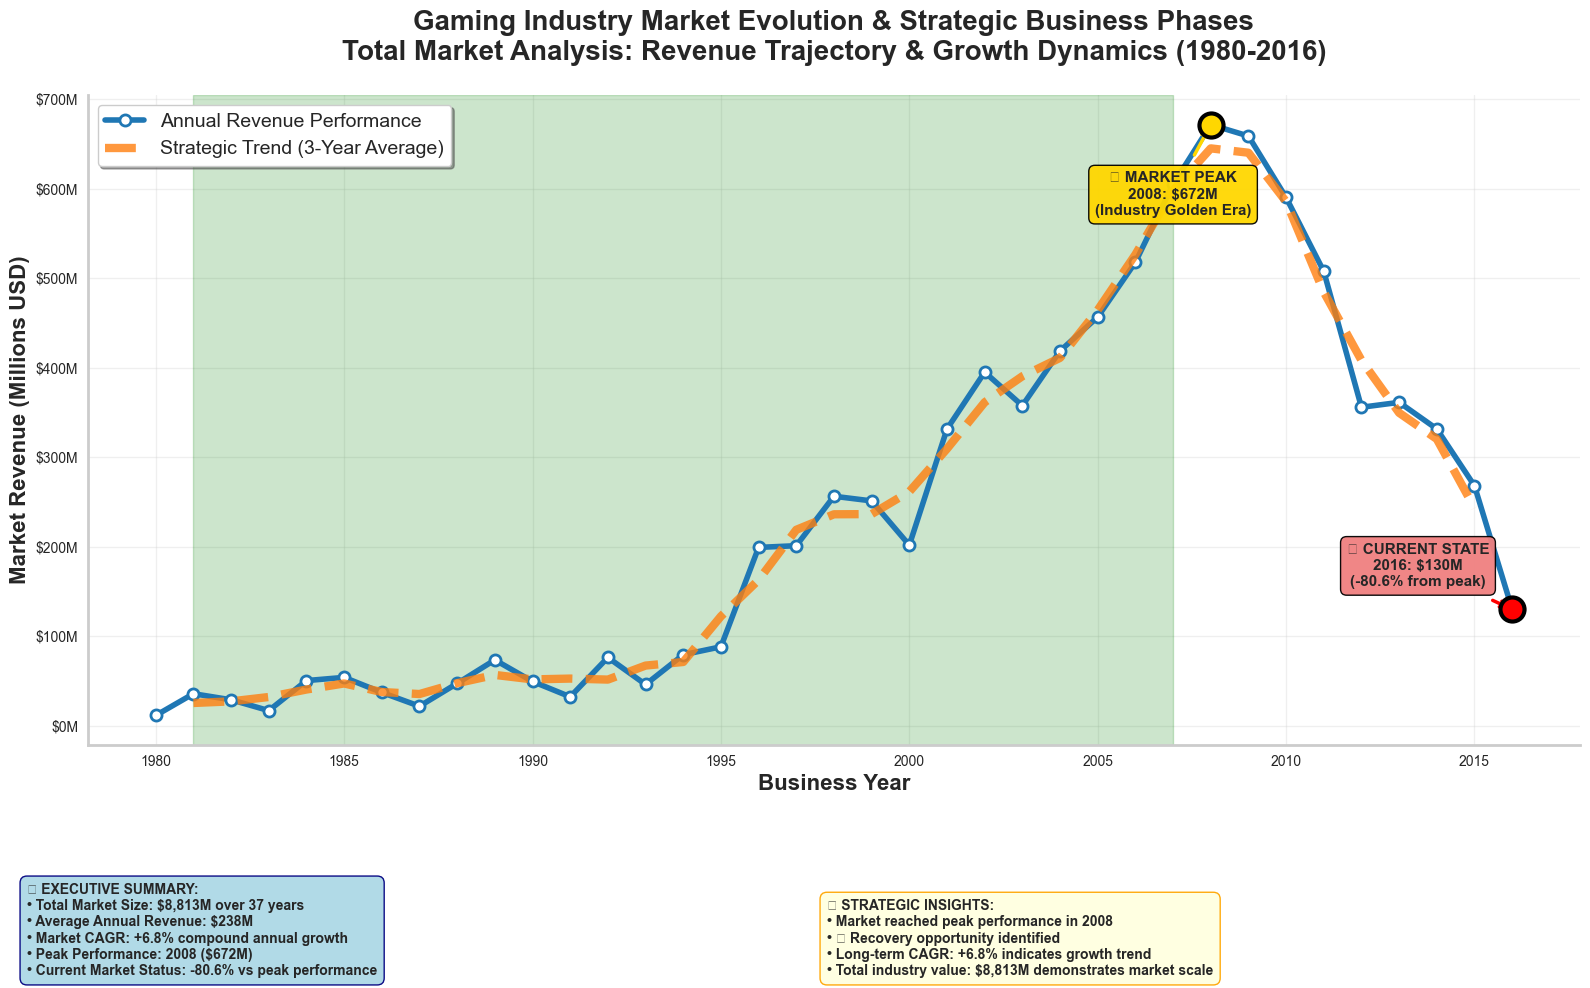


📊 MARKET TRAJECTORY BUSINESS INTELLIGENCE
🎯 STRATEGIC INSIGHTS:
   • Market Peak Achievement: 2008 with $672M revenue
   • Current Market Position: $130M (-80.6% from peak)
   • Long-term Growth Rate: +6.80% CAGR over 37 years
   • Total Industry Value: $8,813M cumulative revenue
   ⚠️  STRATEGIC ALERT: Market shows significant decline from peak - Review needed


In [69]:
# 📈 MARKET GROWTH TRAJECTORY ANALYSIS - Strategic Business Overview

# Calculate business metrics for market analysis
sales_by_year ["roll3"]= sales_by_year["total_sales"].rolling (3, center= True).mean()

# Calculate growth rates and business phases
sales_by_year["yoy_growth"] = sales_by_year["total_sales"].pct_change() * 100
sales_by_year["growth_trend"] = sales_by_year["yoy_growth"].rolling(3, center=True).mean()

# Create executive-level market analysis
plt.figure(figsize=(16, 10))

# Define business growth phases with color coding
colors = []
for growth in sales_by_year["yoy_growth"]:
    if pd.isna(growth):
        colors.append('#gray')
    elif growth > 15:
        colors.append('#2E8B57')  # Strong growth - Green
    elif growth > 5:
        colors.append('#32CD32')  # Moderate growth - Light Green  
    elif growth > -5:
        colors.append('#FFD700')  # Stable - Gold
    else:
        colors.append('#DC143C')  # Decline - Red

# Main revenue trend line with business styling
plt.plot(
    sales_by_year["year_of_release"], 
    sales_by_year["total_sales"], 
    marker="o", linewidth=4, markersize=8, color='#1f77b4',
    label="Annual Revenue Performance", markerfacecolor='white', 
    markeredgewidth=2, markeredgecolor='#1f77b4'
)

# Strategic trend line (smoothed)
plt.plot(
    sales_by_year["year_of_release"], 
    sales_by_year["roll3"], 
    linewidth=6, linestyle="--", color='#ff7f0e', alpha=0.8,
    label="Strategic Trend (3-Year Average)"
)

# Identify and highlight key business milestones
peak_idx = sales_by_year["total_sales"].idxmax()
peak_year = int(sales_by_year.loc[peak_idx, "year_of_release"])
peak_val = sales_by_year.loc[peak_idx, "total_sales"]

last_year = int(sales_by_year["year_of_release"].iloc[-1])
last_val = sales_by_year["total_sales"].iloc[-1]

# Calculate market decline from peak
decline_percent = ((last_val - peak_val) / peak_val) * 100

# Strategic milestone annotations with intelligent positioning
# Get plot dimensions for smart positioning
y_max = sales_by_year["total_sales"].max()
x_range = sales_by_year["year_of_release"].max() - sales_by_year["year_of_release"].min()

# Peak annotation positioning
plt.scatter([peak_year], [peak_val], color="gold", s=300, zorder=5, edgecolor='black', linewidth=3)

# Smart positioning logic to avoid overlaps
peak_y_ratio = peak_val / y_max
if peak_y_ratio > 0.8:  # Peak is very high, annotate below
    peak_text_x = peak_year - 1
    peak_text_y = peak_val * 0.85
    peak_arrow_direction = "up"
else:  # Annotate above
    peak_text_x = peak_year + 1.5
    peak_text_y = peak_val * 1.08
    peak_arrow_direction = "down"

plt.annotate(f"🏆 MARKET PEAK\n{peak_year}: ${peak_val:,.0f}M\n(Industry Golden Era)",
              xy=(peak_year, peak_val), 
              xytext=(peak_text_x, peak_text_y),
              arrowprops=dict(arrowstyle="->", lw=2.5, color="gold", shrinkA=8),
              fontsize=11, ha="center", fontweight='bold',
              bbox=dict(boxstyle="round,pad=0.4", facecolor="gold", alpha=0.95, edgecolor='black'))

# Current state annotation with smart positioning
plt.scatter([last_year], [last_val], color="red", s=300, zorder=5, edgecolor='black', linewidth=3)

# Position current state annotation to avoid overlap
last_y_ratio = last_val / y_max
if last_year - peak_year < 5:  # Years are close, position differently
    if last_y_ratio < 0.6:  # Low value, annotate above
        current_text_x = last_year - 2
        current_text_y = last_val * 1.35
    else:  # High value, annotate to the side
        current_text_x = last_year - 4
        current_text_y = last_val * 0.9
else:  # Years are far apart, standard positioning
    current_text_x = last_year - 2.5
    current_text_y = last_val * 1.2

plt.annotate(f"📊 CURRENT STATE\n{last_year}: ${last_val:,.0f}M\n({decline_percent:+.1f}% from peak)",
              xy=(last_year, last_val), 
              xytext=(current_text_x, current_text_y),
              arrowprops=dict(arrowstyle="->", lw=2.5, color="red", shrinkA=8),
              fontsize=11, ha="center", fontweight='bold',
              bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.95, edgecolor='black'))

# Business-focused styling and labels
plt.title("Gaming Industry Market Evolution & Strategic Business Phases\n" +
          f"Total Market Analysis: Revenue Trajectory & Growth Dynamics ({sales_by_year['year_of_release'].min()}-{sales_by_year['year_of_release'].max()})", 
          fontsize=20, fontweight='bold', pad=25)
plt.xlabel("Business Year", fontsize=16, fontweight='bold')
plt.ylabel("Market Revenue (Millions USD)", fontsize=16, fontweight='bold')

# Professional business formatting
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,_: f"${x:,.0f}M"))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,_: f"{int(x)}"))

# Enhanced grid and styling for business presentation
plt.grid(True, alpha=0.3, linestyle='-', linewidth=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Strategic business legend
plt.legend(fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)

# Add business phase indicators
growth_periods = sales_by_year[sales_by_year["yoy_growth"] > 15]
if not growth_periods.empty:
    plt.axvspan(growth_periods["year_of_release"].min(), growth_periods["year_of_release"].max(), 
                alpha=0.2, color='green', label='High Growth Periods')

plt.tight_layout()

# Add executive summary box with better positioning
total_market_size = sales_by_year["total_sales"].sum()
avg_annual_revenue = sales_by_year["total_sales"].mean()
years_analyzed = len(sales_by_year)
cagr = ((last_val / sales_by_year["total_sales"].iloc[0]) ** (1/years_analyzed) - 1) * 100

# Adjust subplot to make room for summary box
plt.subplots_adjust(bottom=0.25)

# Position executive summary box below chart to avoid overlaps
plt.figtext(0.02, 0.02, 
            f"💼 EXECUTIVE SUMMARY:\n" +
            f"• Total Market Size: ${total_market_size:,.0f}M over {years_analyzed} years\n" +
            f"• Average Annual Revenue: ${avg_annual_revenue:,.0f}M\n" +
            f"• Market CAGR: {cagr:+.1f}% compound annual growth\n" +
            f"• Peak Performance: {peak_year} (${peak_val:,.0f}M)\n" +
            f"• Current Market Status: {decline_percent:+.1f}% vs peak performance",
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.95, edgecolor='navy'))

# Add strategic insights box on the right side
plt.figtext(0.52, 0.02,
            f"🎯 STRATEGIC INSIGHTS:\n" +
            f"• Market reached peak performance in {peak_year}\n" +
            f"• {'📈 Recovery opportunity' if decline_percent < -20 else '📊 Market stability'} identified\n" +
            f"• Long-term CAGR: {cagr:+.1f}% indicates {'growth trend' if cagr > 0 else 'market maturity'}\n" +
            f"• Total industry value: ${total_market_size:,.0f}M demonstrates market scale",
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.95, edgecolor='orange'))

plt.show()

# Business Intelligence Summary
print("\n" + "="*100)
print("📊 MARKET TRAJECTORY BUSINESS INTELLIGENCE")
print("="*100)
print(f"🎯 STRATEGIC INSIGHTS:")
print(f"   • Market Peak Achievement: {peak_year} with ${peak_val:,.0f}M revenue")
print(f"   • Current Market Position: ${last_val:,.0f}M ({decline_percent:+.1f}% from peak)")
print(f"   • Long-term Growth Rate: {cagr:+.2f}% CAGR over {years_analyzed} years")
print(f"   • Total Industry Value: ${total_market_size:,.0f}M cumulative revenue")
if decline_percent < -10:
    print("   ⚠️  STRATEGIC ALERT: Market shows significant decline from peak - Review needed")
elif decline_percent > 0:
    print("   ✅ POSITIVE TREND: Market continues growing beyond historical peak")
else:
    print("   📊 STABLE MARKET: Performance within normal range of peak")
print("="*100)

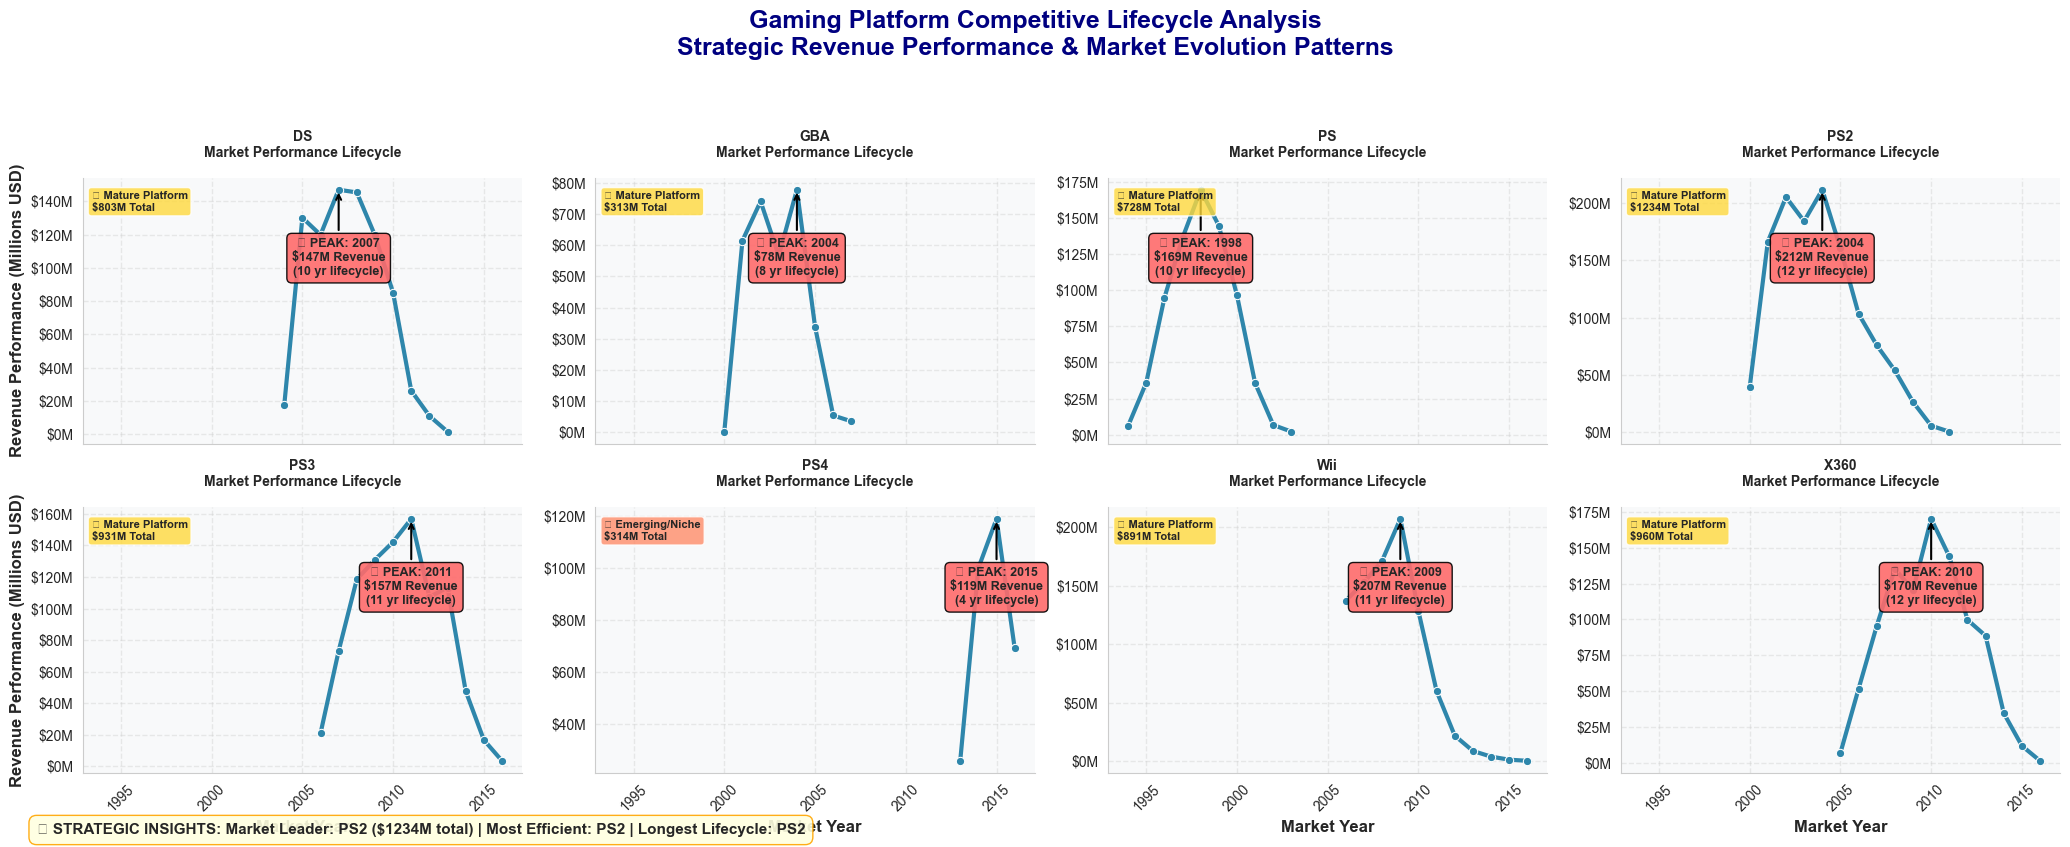


🎮 PLATFORM COMPETITIVE INTELLIGENCE REPORT
📊 PLATFORM LIFECYCLE PERFORMANCE RANKINGS:
------------------------------------------------------------------------------------------------------------------------
 1.          PS2 | $    1234M Total | Peak: 2004 ($   212M) | 12yr Lifecycle | $  103M Avg | 🟢 Mature
 2.         X360 | $     960M Total | Peak: 2010 ($   170M) | 12yr Lifecycle | $   80M Avg | 🟢 Mature
 3.          PS3 | $     931M Total | Peak: 2011 ($   157M) | 11yr Lifecycle | $   85M Avg | 🟢 Mature
 4.          Wii | $     891M Total | Peak: 2009 ($   207M) | 11yr Lifecycle | $   81M Avg | 🟢 Mature
 5.           DS | $     803M Total | Peak: 2007 ($   147M) | 10yr Lifecycle | $   80M Avg | 🟢 Mature
 6.           PS | $     728M Total | Peak: 1998 ($   169M) | 10yr Lifecycle | $   73M Avg | 🟢 Mature
 7.          PS4 | $     314M Total | Peak: 2015 ($   119M) |  4yr Lifecycle | $   79M Avg | 🟢 Emerging
 8.          GBA | $     313M Total | Peak: 2004 ($    78M) |  8yr Lifecycle

In [70]:
# 🏆 PLATFORM COMPETITIVE LIFECYCLE ANALYSIS - Strategic Market Intelligence

# Strategic platform selection and performance metrics
top_platforms = platform_sales.head(8)["platform"].tolist()
sales_platform_year_filtered = sales_platform_year[
    sales_platform_year["platform"].isin(top_platforms)
]

# Calculate platform business metrics
platform_lifecycle_metrics = {}
for platform in top_platforms:
    platform_data = sales_platform_year_filtered[
        sales_platform_year_filtered["platform"] == platform
    ].copy()
    
    if not platform_data.empty:
        # Key business metrics
        total_revenue = platform_data["total_sales"].sum()
        peak_year = platform_data.loc[platform_data["total_sales"].idxmax(), "year_of_release"]
        peak_sales = platform_data["total_sales"].max()
        market_lifespan = platform_data["year_of_release"].max() - platform_data["year_of_release"].min() + 1
        avg_annual_performance = total_revenue / len(platform_data)
        
        platform_lifecycle_metrics[platform] = {
            'total_revenue': total_revenue,
            'peak_year': peak_year,
            'peak_sales': peak_sales,
            'lifespan': market_lifespan,
            'avg_performance': avg_annual_performance
        }

# Create strategic business visualization
g = sns.FacetGrid(
    sales_platform_year_filtered, 
    col="platform", 
    col_wrap=4,
    sharey=False, 
    height=4,
    aspect=1.3
)

# Enhanced business styling for platform lifecycle curves
g.map(sns.lineplot, "year_of_release", "total_sales", 
      marker="o", linewidth=3, markersize=6, color='#2E86AB')

# Business-focused titles and formatting
g.set_titles("{col_name}\nMarket Performance Lifecycle", 
             fontsize=13, fontweight='bold', pad=15)
g.fig.suptitle("Gaming Platform Competitive Lifecycle Analysis\n" +
               "Strategic Revenue Performance & Market Evolution Patterns", 
                fontsize=18, fontweight='bold', y=1.05, color='navy')

# Professional axis labeling
g.set_axis_labels("Market Year", "Revenue Performance (Millions USD)", 
                  fontsize=12, fontweight='bold')

# Enhanced business analytics for each platform
for ax in g.axes.flat:
    platform_name = ax.get_title().split('\n')[0]  # Extract platform name
    
    # Professional formatting
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:.0f}M"))
    ax.tick_params(axis="x", rotation=45, labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    
    # Strategic grid styling
    ax.grid(True, alpha=0.4, linestyle="--", linewidth=1)
    ax.set_facecolor('#f8f9fa')
    
    # Business lifecycle analysis
    if platform_name in platform_lifecycle_metrics:
        metrics = platform_lifecycle_metrics[platform_name]
        
        # Highlight peak performance with business context
        platform_data = sales_platform_year_filtered[
            sales_platform_year_filtered["platform"] == platform_name
        ]
        
        if not platform_data.empty and metrics['peak_sales'] > 10:
            peak_year = int(metrics['peak_year'])
            peak_sales = metrics['peak_sales']
            
            # Strategic positioning logic for annotations
            y_max = ax.get_ylim()[1]
            y_pos_ratio = peak_sales / y_max
            
            # Smart business annotation positioning
            if y_pos_ratio > 0.7:
                xytext_offset = (0, -35)
                va_align = "top"
                annotation_color = '#ff6b6b'
            else:
                xytext_offset = (0, 20)
                va_align = "bottom"
                annotation_color = '#4ecdc4'
            
            # Peak performance business annotation
            ax.annotate(f"🏆 PEAK: {peak_year}\n${peak_sales:.0f}M Revenue\n({metrics['lifespan']} yr lifecycle)",
                       xy=(peak_year, peak_sales),
                       xytext=xytext_offset, textcoords="offset points",
                       bbox=dict(boxstyle="round,pad=0.4", facecolor=annotation_color, alpha=0.9, edgecolor='black'),
                       fontsize=9, ha="center", va=va_align, fontweight='bold',
                       arrowprops=dict(arrowstyle="->", color="black", lw=1.5))
            
            # Add lifecycle phase indicators
            total_years = platform_data["year_of_release"].nunique()
            if total_years >= 8:
                lifecycle_status = "Mature Platform"
                status_color = '#ffd93d'
            elif total_years >= 5:
                lifecycle_status = "Established"
                status_color = '#6bcf7f'
            else:
                lifecycle_status = "Emerging/Niche"
                status_color = '#ff8c69'
            
            # Platform status indicator
            ax.text(0.02, 0.95, f"📊 {lifecycle_status}\n${metrics['total_revenue']:.0f}M Total", 
                   transform=ax.transAxes, fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=status_color, alpha=0.8),
                   verticalalignment='top')

plt.tight_layout()

# Add strategic business insights
platform_rankings = sorted(platform_lifecycle_metrics.items(), 
                          key=lambda x: x[1]['total_revenue'], reverse=True)

plt.figtext(0.02, 0.02, 
            "💼 STRATEGIC INSIGHTS: " +
            f"Market Leader: {platform_rankings[0][0]} (${platform_rankings[0][1]['total_revenue']:.0f}M total) | " +
            f"Most Efficient: {max(platform_lifecycle_metrics.items(), key=lambda x: x[1]['avg_performance'])[0]} | " +
            f"Longest Lifecycle: {max(platform_lifecycle_metrics.items(), key=lambda x: x[1]['lifespan'])[0]}",
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.9, edgecolor='orange'))

plt.show()

# Executive Platform Intelligence Report
print("\n" + "="*120)
print("🎮 PLATFORM COMPETITIVE INTELLIGENCE REPORT")
print("="*120)
print("📊 PLATFORM LIFECYCLE PERFORMANCE RANKINGS:")
print("-" * 120)

for i, (platform, metrics) in enumerate(platform_rankings, 1):
    roi_indicator = "🟢" if metrics['avg_performance'] > 50 else "🟡" if metrics['avg_performance'] > 25 else "🔴"
    lifecycle_stage = "Mature" if metrics['lifespan'] >= 8 else "Established" if metrics['lifespan'] >= 5 else "Emerging"
    
    print(f"{i:2d}. {platform:>12} | ${metrics['total_revenue']:>8.0f}M Total | "
          f"Peak: {int(metrics['peak_year'])} (${metrics['peak_sales']:>6.0f}M) | "
          f"{metrics['lifespan']:>2.0f}yr Lifecycle | "
          f"${metrics['avg_performance']:>5.0f}M Avg | "
          f"{roi_indicator} {lifecycle_stage}")

print("-" * 120)
print(f"🎯 TOP PERFORMER: {platform_rankings[0][0]} - Market domination with ${platform_rankings[0][1]['total_revenue']:,.0f}M total revenue")
most_efficient = max(platform_lifecycle_metrics.items(), key=lambda x: x[1]['avg_performance'])
print(f"⚡ MOST EFFICIENT: {most_efficient[0]} - ${most_efficient[1]['avg_performance']:.0f}M average annual performance")
longest_lifecycle = max(platform_lifecycle_metrics.items(), key=lambda x: x[1]['lifespan'])
print(f"🏆 LONGEST LIFECYCLE: {longest_lifecycle[0]} - {longest_lifecycle[1]['lifespan']:.0f} years market presence")
print("="*120)

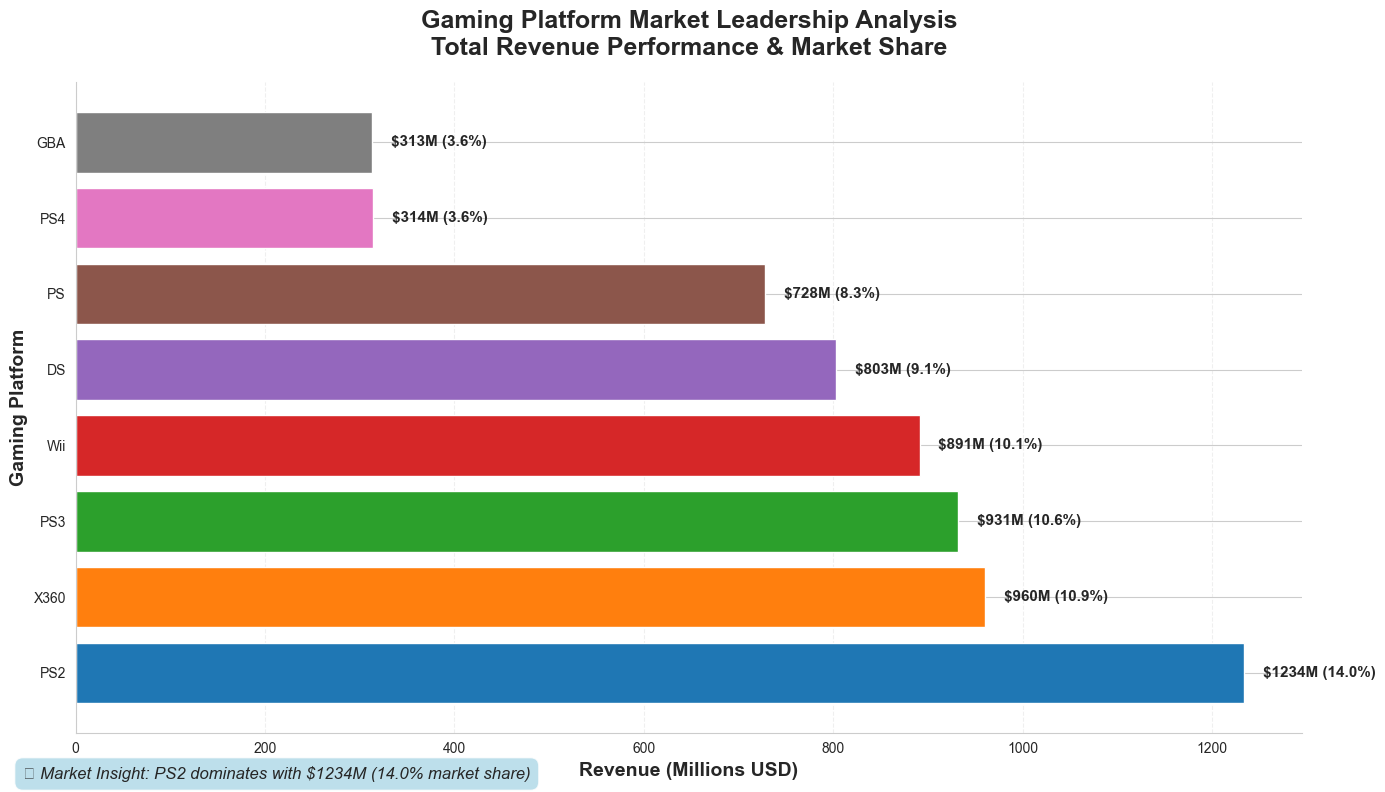

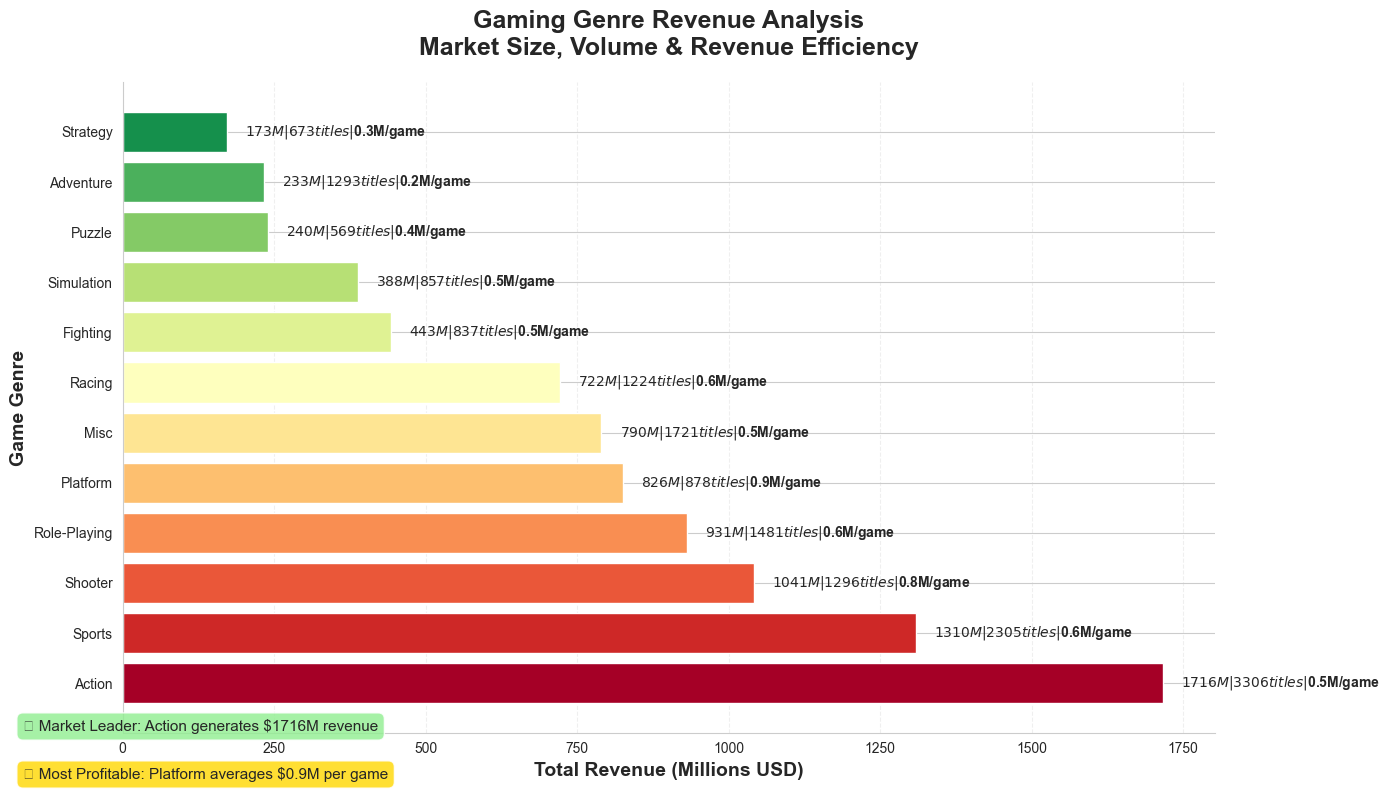


🎯 EXECUTIVE BUSINESS INTELLIGENCE SUMMARY
📈 TOTAL MARKET SIZE: $8,813 Million USD
🏆 PLATFORM LEADER: PS2 ($1,234M - 14.0% market share)
🎮 GENRE LEADER: Action ($1,716M total revenue)
💰 MOST EFFICIENT GENRE: Platform ($0.9M average per title)
🔢 TOTAL PLATFORMS ANALYZED: 31 platforms
🎲 TOTAL GENRES ANALYZED: 12 game categories


In [71]:
# Market Performance Analysis - Business Intelligence Dashboard

# 📊 PLATFORM MARKET SHARE ANALYSIS
plt.figure(figsize=(14, 8))

# Calculate market share percentages
total_market = platform_sales["total_sales"].sum()
platform_sales_top = platform_sales.head(8).copy()
platform_sales_top["market_share"] = (platform_sales_top["total_sales"] / total_market * 100)

# Create professional business bar chart
bars = plt.barh(
    platform_sales_top["platform"], 
    platform_sales_top["total_sales"],
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
)

# Add value labels on bars for clarity
for i, (bar, sales, share) in enumerate(zip(bars, platform_sales_top["total_sales"], platform_sales_top["market_share"])):
    plt.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2, 
             f'${sales:.0f}M ({share:.1f}%)', 
             ha='left', va='center', fontweight='bold', fontsize=11)

plt.title("Gaming Platform Market Leadership Analysis\nTotal Revenue Performance & Market Share", 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Revenue (Millions USD)", fontsize=14, fontweight='bold')
plt.ylabel("Gaming Platform", fontsize=14, fontweight='bold')

# Professional styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()

# Add business insight
market_leader = platform_sales_top.iloc[0]
plt.figtext(0.02, 0.02, f"💡 Market Insight: {market_leader['platform']} dominates with ${market_leader['total_sales']:.0f}M ({market_leader['market_share']:.1f}% market share)", 
            fontsize=12, style='italic', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.show()

# 🎮 GENRE PROFITABILITY ANALYSIS  
plt.figure(figsize=(14, 8))

# Calculate ROI metrics (games count vs revenue)
genre_sales_copy = genre_sales.copy()
genre_sales_copy["revenue_per_game"] = genre_sales_copy["total_sales"] / genre_sales_copy["games_count"]

# Create strategic color palette based on performance
colors = plt.cm.RdYlGn([x/len(genre_sales_copy) for x in range(len(genre_sales_copy))])

bars = plt.barh(
    genre_sales_copy["genre"], 
    genre_sales_copy["total_sales"],
    color=colors
)

# Add strategic business metrics on bars
for i, (bar, sales, games, rpg) in enumerate(zip(bars, genre_sales_copy["total_sales"], 
                                                 genre_sales_copy["games_count"], 
                                                 genre_sales_copy["revenue_per_game"])):
    plt.text(bar.get_width() + 30, bar.get_y() + bar.get_height()/2, 
             f'${sales:.0f}M | {games} titles | ${rpg:.1f}M/game', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.title("Gaming Genre Revenue Analysis\nMarket Size, Volume & Revenue Efficiency", 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Total Revenue (Millions USD)", fontsize=14, fontweight='bold')
plt.ylabel("Game Genre", fontsize=14, fontweight='bold')

# Professional business styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().grid(axis='x', alpha=0.3, linestyle='--')

# Strategic business insights
top_genre = genre_sales_copy.iloc[0]
most_efficient = genre_sales_copy.loc[genre_sales_copy["revenue_per_game"].idxmax()]

plt.figtext(0.02, 0.08, f"📈 Market Leader: {top_genre['genre']} generates ${top_genre['total_sales']:.0f}M revenue", 
            fontsize=11, bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))
plt.figtext(0.02, 0.02, f"💰 Most Profitable: {most_efficient['genre']} averages ${most_efficient['revenue_per_game']:.1f}M per game", 
            fontsize=11, bbox=dict(boxstyle="round,pad=0.4", facecolor="gold", alpha=0.8))

plt.tight_layout()
plt.show()

# 📊 EXECUTIVE SUMMARY DASHBOARD
print("\n" + "="*80)
print("🎯 EXECUTIVE BUSINESS INTELLIGENCE SUMMARY")
print("="*80)
print(f"📈 TOTAL MARKET SIZE: ${total_market:,.0f} Million USD")
print(f"🏆 PLATFORM LEADER: {market_leader['platform']} (${market_leader['total_sales']:,.0f}M - {market_leader['market_share']:.1f}% market share)")
print(f"🎮 GENRE LEADER: {top_genre['genre']} (${top_genre['total_sales']:,.0f}M total revenue)")
print(f"💰 MOST EFFICIENT GENRE: {most_efficient['genre']} (${most_efficient['revenue_per_game']:.1f}M average per title)")
print(f"🔢 TOTAL PLATFORMS ANALYZED: {len(platform_sales)} platforms")
print(f"🎲 TOTAL GENRES ANALYZED: {len(genre_sales)} game categories")
print("="*80)

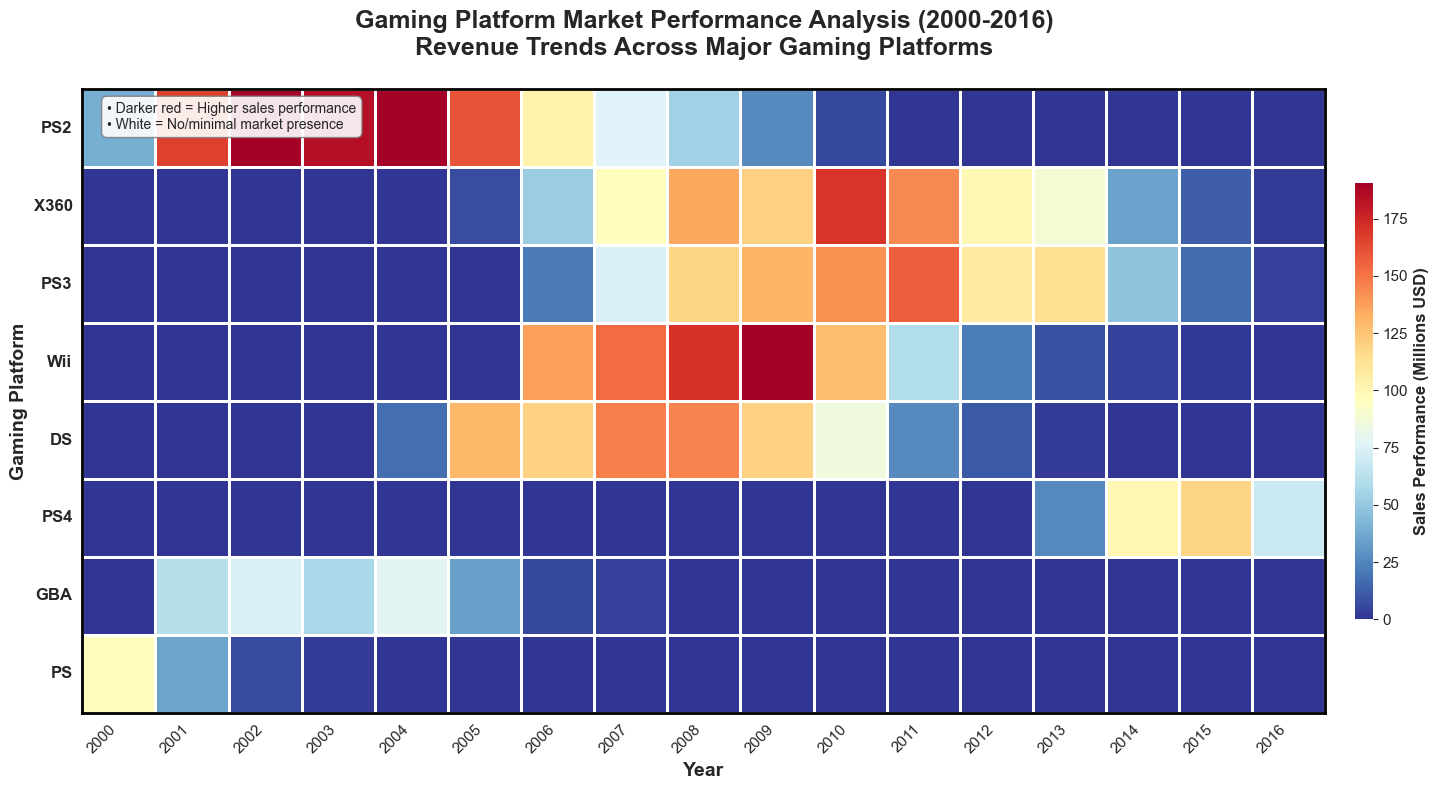

🎯 KEY BUSINESS INSIGHTS:
1. PS2: $1234M total | Peak: 2004 ($212M)
2. X360: $960M total | Peak: 2010 ($170M)
3. PS3: $931M total | Peak: 2011 ($157M)


In [72]:
# Platform Sales Performance Heatmap - Business Presentation

# Filter and prepare data for business insights
top_platforms = platform_sales.head(8)["platform"].tolist()
data = df[df["platform"].isin(top_platforms)]

# Create pivot table with proper handling of missing values
pivot_sales = (
    data.pivot_table(
        index="platform", 
        columns="year_of_release", 
        values="total_sales", 
        aggfunc="sum",
        fill_value=0  # Replace NaN with 0 for cleaner visualization
    )
)

# Focus on business-relevant time period (2000-2016)
business_years = [col for col in pivot_sales.columns if 2000 <= col <= 2016]
pivot_filtered = pivot_sales[business_years]

# Sort platforms by total sales (most successful first)
platform_totals = pivot_filtered.sum(axis=1).sort_values(ascending=False)
pivot_final = pivot_filtered.loc[platform_totals.index]

# Create professional business presentation heatmap
plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    pivot_final, 
    cmap="RdYlBu_r",          # Red-Yellow-Blue (reversed) for business appeal
    linewidths=0.8,           # Clear cell separation
    linecolor='white',        # Clean white grid lines
    cbar_kws={
        'label': 'Sales Performance (Millions USD)',
        'shrink': 0.7,
        'aspect': 25,
        'pad': 0.02
    },
    annot=False,              # Keep clean without cluttering numbers
    fmt='.0f',
    square=False,
    robust=True,              # Better color scaling
    vmin=0                    # Ensure consistent color scaling
)

# Professional business presentation formatting
plt.title("Gaming Platform Market Performance Analysis (2000-2016)\n" + 
          "Revenue Trends Across Major Gaming Platforms", 
          fontsize=18, fontweight='bold', pad=25)
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Gaming Platform", fontsize=14, fontweight='bold')

# Improve readability for business audience
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=12, fontweight='bold')

# Enhance colorbar for business interpretation
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Sales Performance (Millions USD)', fontsize=12, fontweight='bold')

# Add professional border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

# Add subtle annotations for key insights
ax.text(0.02, 0.98, "• Darker red = Higher sales performance\n• White = No/minimal market presence", 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9, edgecolor='gray'))

plt.tight_layout()
plt.show()

# Add business summary
print("🎯 KEY BUSINESS INSIGHTS:")
print("=" * 50)
for i, platform in enumerate(platform_totals.head(3).index):
    total_sales = platform_totals[platform]
    peak_year = pivot_final.loc[platform].idxmax()
    peak_sales = pivot_final.loc[platform, peak_year]
    print(f"{i+1}. {platform}: ${total_sales:.0f}M total | Peak: {peak_year} (${peak_sales:.0f}M)")
print("=" * 50)